In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from plot_functions import return_list, format_number, get_token_symbol, plot_metric_chart
from matplotlib.ticker import FuncFormatter
import numpy as np


In [2]:
def plot_three_metrics_all(data_dict_all, chain_name, window_size=60, threshold=2):
    """
    Plot three metrics (fee, TVL, and Price) for a given chain on a single figure.
    The x-axis (date) is shared across all three subplots.

    Parameters:
    - data_dict_all (dict): Dictionary containing all data.
    - chain_name (str): The name of the chain to plot.
    - window_size (int): Rolling window size for Z-score calculation on TVL'.
    - threshold (int): Z-score threshold for anomaly detection on TVL'.
    """
    # Check if all required data exists
    token_symbol = get_token_symbol(chain_name)
    if 'fee' not in data_dict_all or 'tvl' not in data_dict_all or 'price' not in data_dict_all:
        print("Missing one or more required datasets (fee, tvl, price) in data_dict_all.")
        return

    if chain_name not in data_dict_all['fee'] or chain_name not in data_dict_all['tvl'] or chain_name not in data_dict_all['price']:
        print(f"Data for chain {chain_name} is missing in one or more datasets.")
        return

    required_rows = 365*2 + window_size
    fee_df = data_dict_all['fee'][chain_name].copy().tail(required_rows)
    tvl_df = data_dict_all['tvl'][chain_name].copy().tail(required_rows)
    price_df = data_dict_all['price'][chain_name].copy().tail(required_rows)

    fee_df.rename(columns={'value': 'value_fee'}, inplace=True)
    tvl_df.rename(columns={'value': 'value_tvl'}, inplace=True)
    price_df.rename(columns={'value': 'value_price'}, inplace=True)

    fee_df['date'] = pd.to_datetime(fee_df['date'])
    tvl_df['date'] = pd.to_datetime(tvl_df['date'])
    price_df['date'] = pd.to_datetime(price_df['date'])

    merged_df = fee_df.merge(tvl_df, on='date', suffixes=('_fee', '_tvl'))
    merged_df = merged_df.merge(price_df, on='date')

    merged_df['value_fee_coin'] = merged_df['value_fee'] / merged_df['value_price']
    merged_df['tvl_prime'] = merged_df['value_tvl'] / merged_df['value_price']

    merged_df['tvl_prime_log'] = np.log(merged_df['tvl_prime'])
    merged_df['log_return'] = merged_df['tvl_prime_log'].diff()

    merged_df['rolling_mean'] = merged_df['log_return'].rolling(window=window_size, min_periods=1).mean()
    merged_df['rolling_std'] = merged_df['log_return'].rolling(window=window_size, min_periods=1).std()
    merged_df['rolling_std'] = merged_df['rolling_std'].replace({0: np.nan})
    merged_df['Z_score'] = (merged_df['log_return'] - merged_df['rolling_mean']) / merged_df['rolling_std']
    merged_df['is_anomaly'] = merged_df['Z_score'].abs() > threshold

    # Apply dark background style with deeper color
    plt.style.use("dark_background")

    for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
        plt.rcParams[param] = '0.8'  # light grey

    for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
        plt.rcParams[param] = '#1B1B2F'  # deeper dark grey

    colors = [
        '#08F7FE',  # teal/cyan
        '#FE53BB',  # pink
        '#F5D300',  # yellow
        '#00ff41',  # matrix green
    ]

    fig, axes = plt.subplots(3, 1, figsize=(14, 14), sharex=True, gridspec_kw={'hspace': 0.4})


    # Plot Fee in ETH
    axes[0].plot(merged_df['date'], merged_df['value_fee_coin'], color=colors[0], linewidth=1)
    axes[0].fill_between(merged_df['date'], merged_df['value_fee_coin'], color=colors[0], alpha=0.1)
    
    # Adjust the y-axis scale for Fee in ETH
    fee_min = merged_df['value_fee_coin'].min() * 0.9
    fee_max = merged_df['value_fee_coin'].max() * 1.1
    axes[0].set_ylim(fee_min, fee_max)
    axes[0].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{format_number(x)} {token_symbol}'))
    
    axes[0].set_title(f'Fee Over Time', loc='left', fontsize=14, fontweight='bold')

    # Plot TVL' with anomalies
    axes[1].plot(merged_df['date'], merged_df['tvl_prime'], color=colors[1], linewidth=1, label="TVL'")

    # Highlight anomalies
    anomalies = merged_df[merged_df['is_anomaly']]
    axes[1].scatter(anomalies['date'], anomalies['tvl_prime'], color=colors[3], s=30, edgecolor='black', label='Anomalies', zorder=5)

    # Fill the area below TVL'
    axes[1].fill_between(merged_df['date'], merged_df['tvl_prime'], color=colors[1], alpha=0.1)

    # Adjust the y-axis scale for TVL' and format as millions
    tvl_min = merged_df['tvl_prime'].min() * 0.9
    tvl_max = merged_df['tvl_prime'].max() * 1.1
    axes[1].set_ylim(tvl_min, tvl_max)
    axes[1].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{format_number(x)} {token_symbol}'))

    axes[1].set_title(f"TVL' Over Time with Anomalies", loc='left', fontsize=14, fontweight='bold')

    # Ensure proper alignment with x-axis
    axes[1].tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=False)

    # Plot Price
    axes[2].plot(merged_df['date'], merged_df['value_price'], color=colors[2], linewidth=1)
    axes[2].fill_between(merged_df['date'], merged_df['value_price'], color=colors[2], alpha=0.1)

    # Adjust the y-axis scale for Price
    price_min = merged_df['value_price'].min() * 0.9
    price_max = merged_df['value_price'].max() * 1.1
    axes[2].set_ylim(price_min, price_max)
    axes[2].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{format_number(x)} USD'))    
    axes[2].set_title(f'Price Over Time', loc='left', fontsize=14, fontweight='bold')

    # Format plots
    for ax in axes:
        ax.grid(color='#2A3459')
        ax.set_xlim([merged_df['date'].iloc[0], merged_df['date'].iloc[-1]])
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        ax.set_facecolor('#1B1B2F')
        
        for spine in ax.spines.values():
            spine.set_visible(False)

    
    fig.suptitle(f'{chain_name} Three Metrics Over Time', fontsize=16, fontweight='bold', color='white')

    # plt.tight_layout()
    
    output_folder = './results/z_score_charts'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    plt.savefig(os.path.join(output_folder, f'{chain_name}_3.png'))
    print(f"{chain_name} TVL' Z-Score chart with Price has been saved ({chain_name}_3.png)")
    
    plt.show()

Ethereum TVL' Z-Score chart with Price has been saved (Ethereum_3.png)


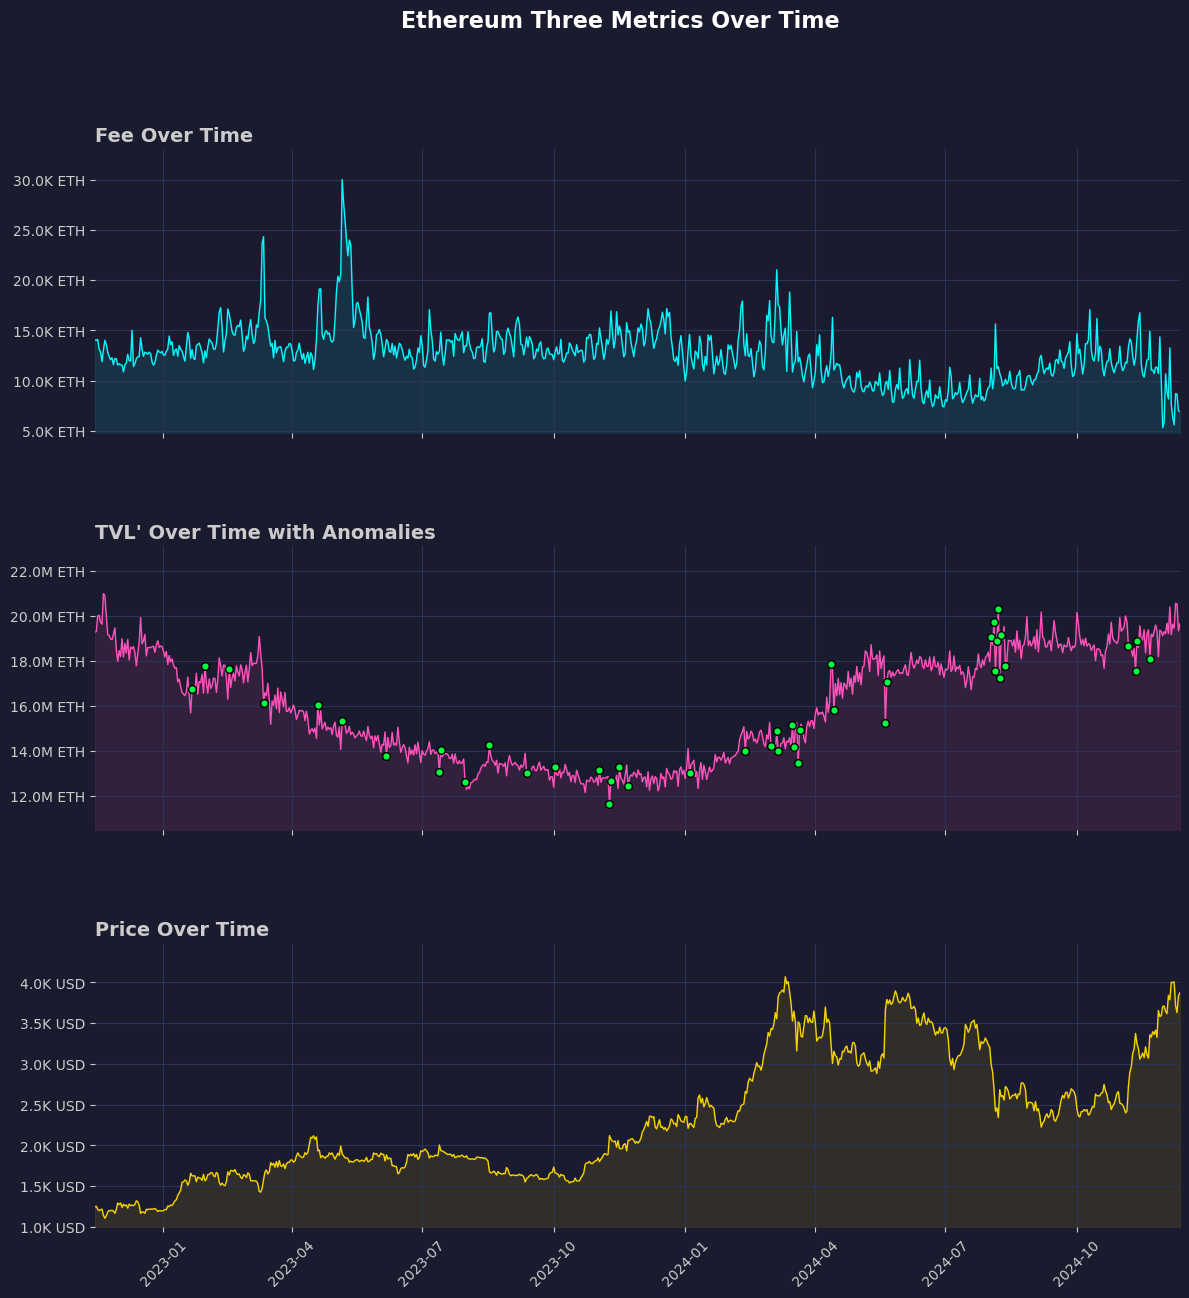

Solana TVL' Z-Score chart with Price has been saved (Solana_3.png)


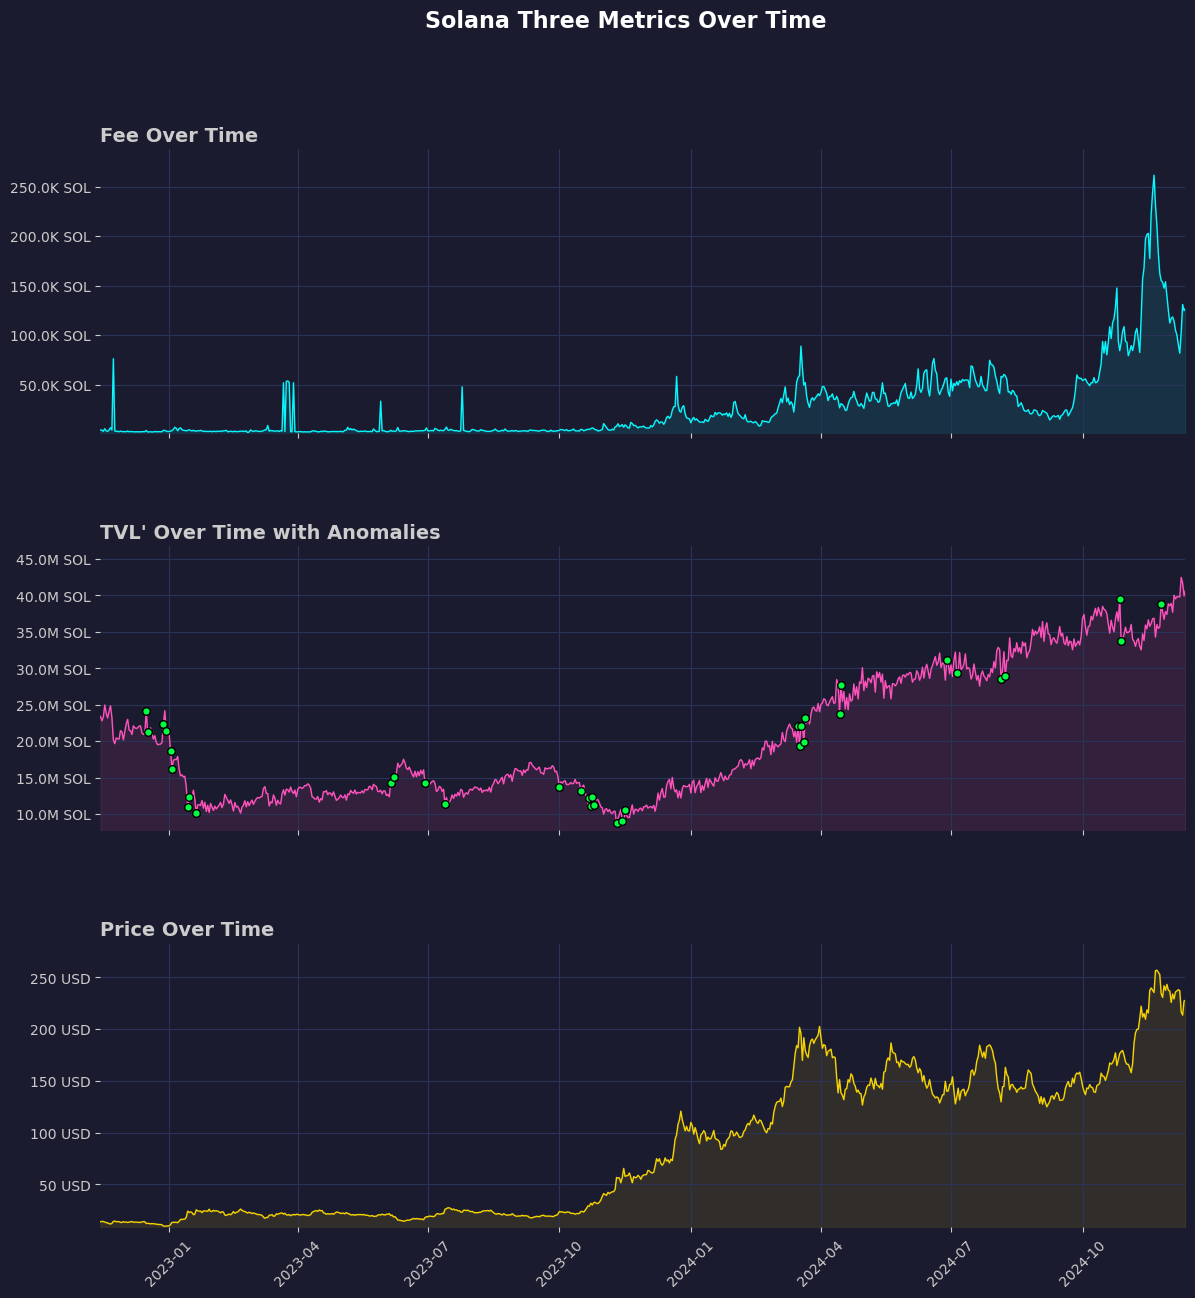

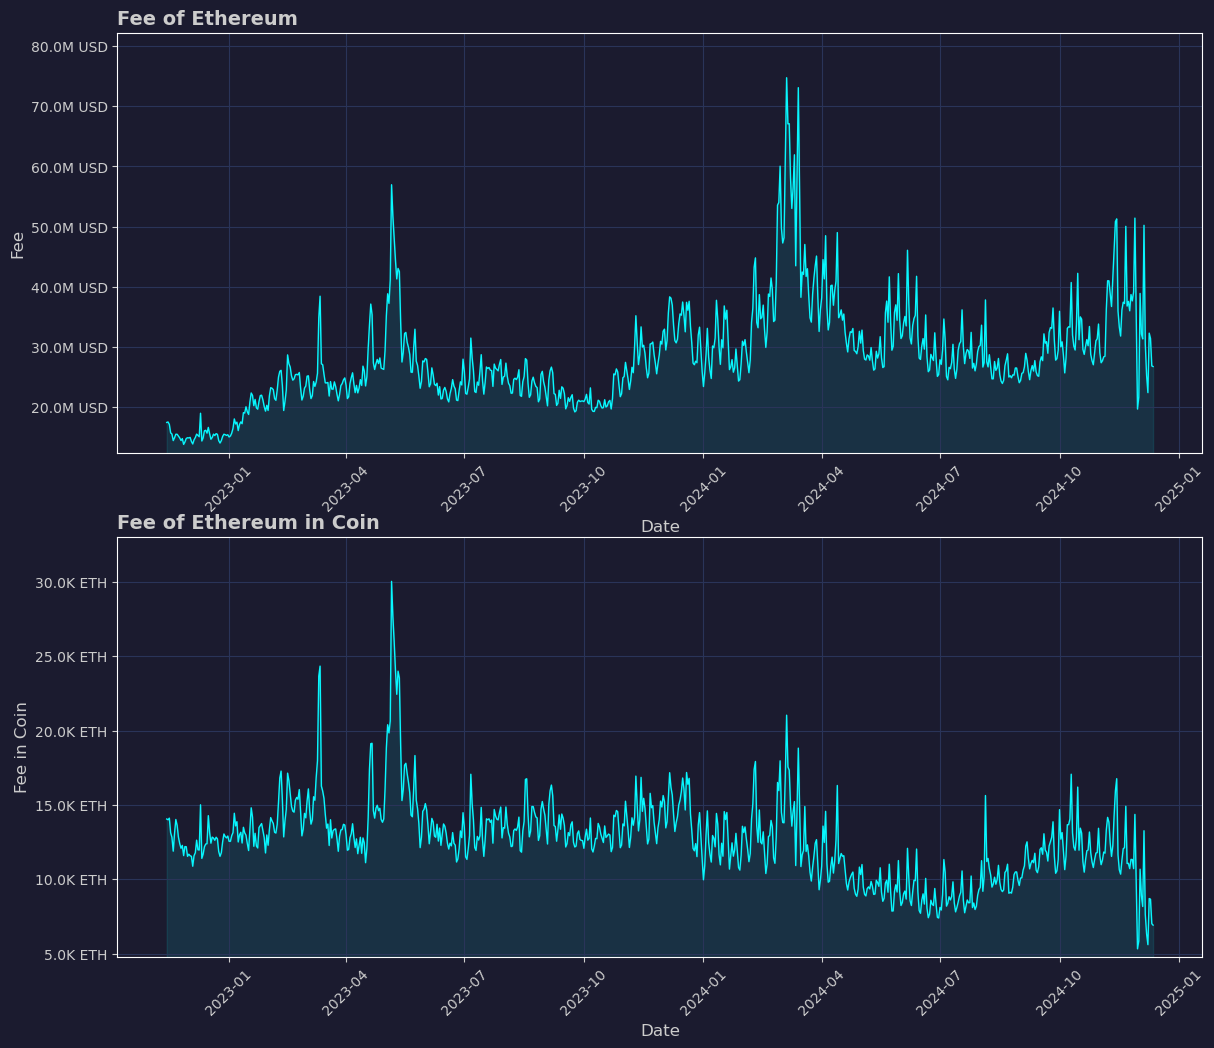

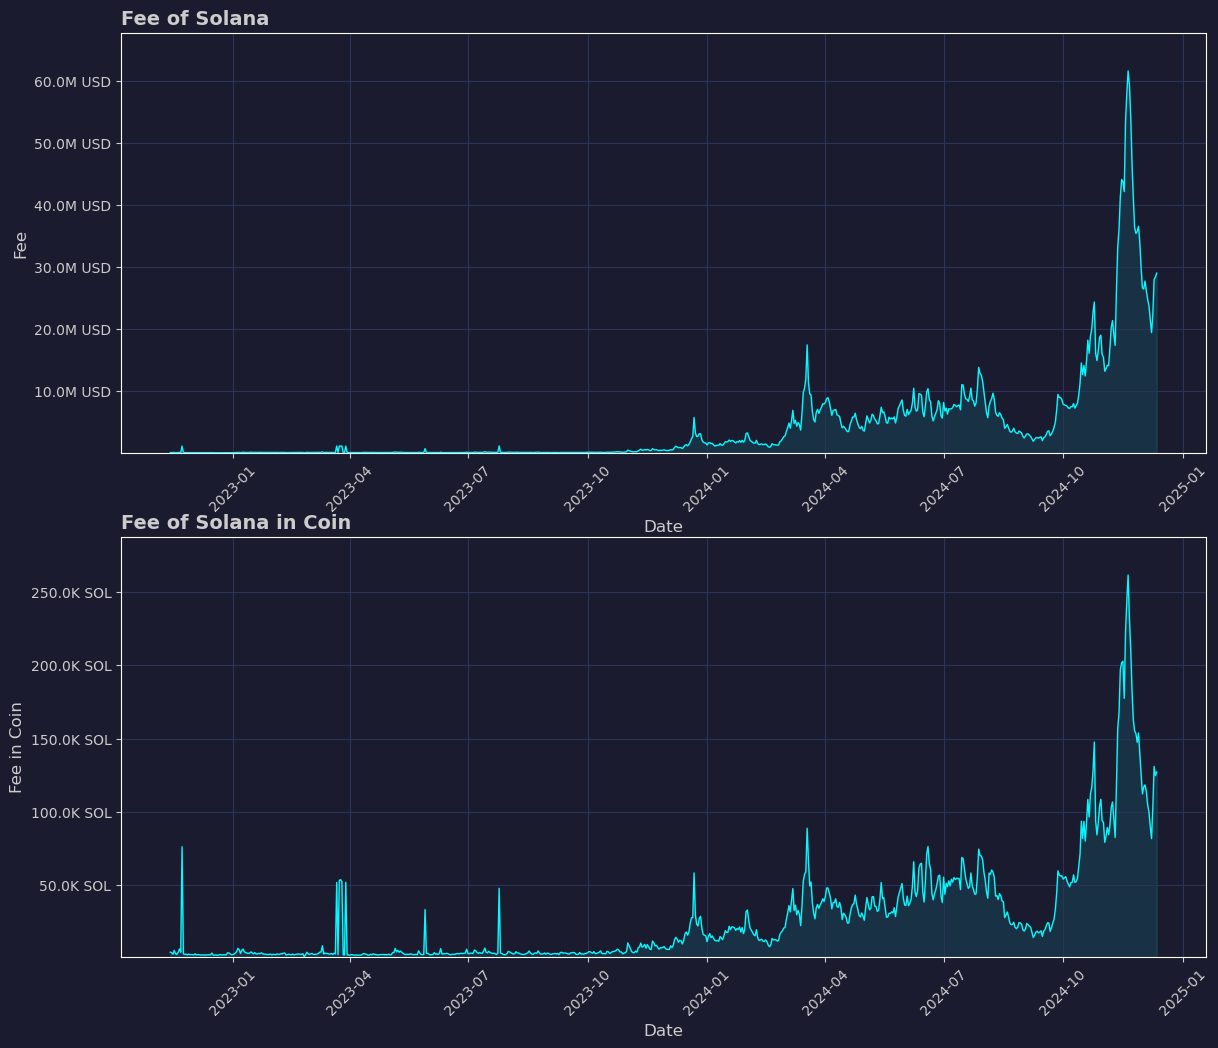

In [3]:
name_list = return_list() # get the name list of the chains

data_folder = 'data'
subfolders = ['fee', 'tvl', 'volume', 'price']

data_dict = {} # this one is for the last 365*2 days
data_dict_all = {} # this one is for all data, cuz we need to compute z-score

# read data
for subfolder in subfolders:
    folder_path = os.path.join(data_folder, subfolder)
    if os.path.exists(folder_path):
        csv_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.csv')])

        data_dict[subfolder] = {}
        data_dict_all[subfolder] = {}

        for csv_file in csv_files:
            chain_name = csv_file.split('_')[1]

            csv_path = os.path.join(folder_path, csv_file)
            df = pd.read_csv(csv_path)

            df.columns = ['date', 'value'] if subfolder == 'fee' else ['date', subfolder]
            df.rename(columns={subfolder: 'value'}, inplace=True)
            df['date'] = pd.to_datetime(df['date'])

            data_dict[subfolder][chain_name] = df.tail(365*2)
            data_dict_all[subfolder][chain_name] = df




# for name in name_list['name']:
#     if name == 'Base':
#         continue
#     plot_three_metrics_all(data_dict_all, chain_name=name)

plot_three_metrics_all(data_dict_all, chain_name='Ethereum', window_size=60, threshold=2)
plot_three_metrics_all(data_dict_all, chain_name='Solana', window_size=60, threshold=2) 

plot_metric_chart(data_dict_all, 'Ethereum', 'fee')
plot_metric_chart(data_dict_all, 'Solana', 'fee')

